# Project Goal

This project aims to develop a machine learning-based system to detect Distributed Denial of Service (DDoS) attacks in cloud environments using supervised classification techniques.

The dataset used — the BCCC CPacket Cloud DDoS 2024 — contains labeled network traffic samples categorized into three main classes:

- BENIGN (legitimate traffic),

- SUSPICIOUS (potential threat),

- ATTACK (confirmed malicious activity).

This makes the problem a multi-class classification task, where the objective is not only to distinguish between normal and malicious traffic, but also to identify potentially dangerous patterns before they escalate into real attacks.

The overall goal is to identify the most reliable model that can distinguish between normal and attack traffic with high accuracy, while minimising false negatives — i.e., ensuring that as few attacks as possible go undetected.

To achieve this, the project follows these key steps:

- Load and clean the dataset by removing irrelevant, redundant, and malformed entries.

- Explore the structure and class distribution of the data.

- Preprocess the data with appropriate transformations (e.g., scaling, encoding).

- Train and evaluate several classification algorithms (Random Forest, Logistic Regression, etc.).

- Compare models using precision, recall, F1-score, and ROC AUC metrics.

- Select the best-performing model based on its ability to correctly detect attacks, with special focus on recall for the attack class.

# 0. Initial Setup

In [31]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Initial Data Loading and Cleaning

In [32]:
df = pd.read_csv('/content/drive/MyDrive/cloud-DDOS.csv')

/tmp/ipython-input-32-3928479655.py:1: DtypeWarning: Columns (3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,26

I check the dataset in order to see what it contains and what attributes can be removed. I can see that i have 324 columns and a mix of categorical and numerical features.

In [33]:
df.head()

,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,...,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label,activity
0,35.203.211.133_54573_10.0.4.57_25094_TCP_2023-...,2023-12-14 09:01:03.508091,35.203.211.133,54573,10.0.4.57,25094,TCP,0.000063,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Benign,Benign
1,10.0.4.57_25094_35.203.211.133_54573_TCP_2023-...,2023-12-14 09:01:03.508156,10.0.4.57,25094,35.203.211.133,54573,TCP,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,35.203.211.133_54573_10.0.4.57_25094_TCP_2023-...,2023-12-14 09:01:03.508431,35.203.211.133,54573,10.0.4.57,25094,TCP,0.000028,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,162.142.125.181_9147_10.0.4.57_18060_TCP_2023-...,2023-12-14 09:01:06.696817,162.142.125.181,9147,10.0.4.57,18060,TCP,0.000055,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Benign,Benign
4,10.0.4.57_18060_162.142.125.181_9147_TCP_2023-...,2023-12-14 09:01:06.696874,10.0.4.57,18060,162.142.125.181,9147,TCP,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


I decided to remove the 'flow_id' column because it's a composite of all the other columns and isn't useful for training the model.

In [34]:
# Remove flow_id as it's not useful for training
df.drop("flow_id", axis=1, inplace=True)

In [35]:
#Check all columns name
header_names = df.columns.values.tolist()
print(*header_names, sep = "\n")

timestamp
src_ip
src_port
dst_ip
dst_port
protocol
duration
packets_count
fwd_packets_count
bwd_packets_count
total_payload_bytes
fwd_total_payload_bytes
bwd_total_payload_bytes
payload_bytes_max
payload_bytes_min
payload_bytes_mean
payload_bytes_std
payload_bytes_variance
payload_bytes_median
payload_bytes_skewness
payload_bytes_cov
payload_bytes_mode
fwd_payload_bytes_max
fwd_payload_bytes_min
fwd_payload_bytes_mean
fwd_payload_bytes_std
fwd_payload_bytes_variance
fwd_payload_bytes_median
fwd_payload_bytes_skewness
fwd_payload_bytes_cov
fwd_payload_bytes_mode
bwd_payload_bytes_max
bwd_payload_bytes_min
bwd_payload_bytes_mean
bwd_payload_bytes_std
bwd_payload_bytes_variance
bwd_payload_bytes_median
bwd_payload_bytes_skewness
bwd_payload_bytes_cov
bwd_payload_bytes_mode
total_header_bytes
max_header_bytes
min_header_bytes
mean_header_bytes
std_header_bytes
median_header_bytes
skewness_header_bytes
cov_header_bytes
mode_header_bytes
variance_header_bytes
fwd_total_header_bytes
fwd_max_h

## Remove all NaN

I check how many columns have NaN values

In [36]:
# Checking all the NaN value in the dataset
nan = df.isnull().sum()[df.isnull().sum() > 0]
nan

,0
timestamp,2
payload_bytes_skewness,540271
payload_bytes_cov,540111
fwd_payload_bytes_skewness,476027
fwd_payload_bytes_cov,475285
bwd_payload_bytes_skewness,196913
bwd_payload_bytes_cov,196675
skewness_header_bytes,456723
fwd_skewness_header_bytes,477282
bwd_skewness_header_bytes,175973


I decided to remove all NaN values because they are not too many and will not give issues with classifications. This way i will have a clean dataset without missing values.


In [37]:
# Removing all row with at least 1 NaN value
righe = df[df.notnull().all(axis=1)]
label = righe['label'].value_counts()
df=righe
label

,count
label,
Benign,60243
Attack,57654
Suspicious,37903
label,2


 ## Manage "Label" column

By examining the label distribution of the dataset, I've identified a potential issue with a value simply called 'label'. As it only has two instances, I can safely drop it without negatively impacting the classification, so that i have the 3 classes that i need to classify without mistakes.

In [38]:
# Checking available values of labels
df['label'].unique()

array(['Benign', 'label', 'Attack', 'Suspicious'], dtype=object)

In [39]:
# Removing wrong value in label feature
df = df[df['label'] != "label"]
df['label'].unique()

array(['Benign', 'Attack', 'Suspicious'], dtype=object)

In [40]:
#Check label count
label = df['label'].value_counts()
label

,count
label,
Benign,60243
Attack,57654
Suspicious,37903


I check to see how it is distributed in a pie chart, i can see that is it almost balanced so i decided to not do any type of oversampling for the suspicious class.

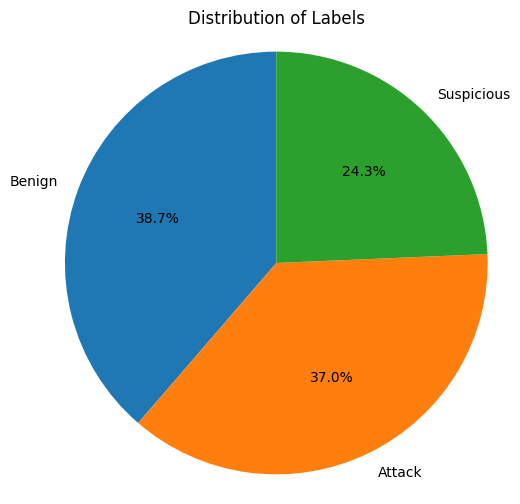

In [41]:
# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label, labels=label.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

I check if there are any type of duplicated values, i can see that there are none so i don't have to worry about it.

In [42]:
# check duplicated
df.duplicated()

,0
35,False
72,False
73,False
74,False
75,False
...,...
700767,False
700768,False
700770,False
700771,False


# 2. Data Type Handling and Preprocessing

## Checking column types and fix types (remove id)

I'm now checking if the columns have the correct data types. I see that all columns are currently of the object type. This is because values like '5' are present as both numbers and strings. I'll handle the type casting later.

In [43]:
df.dtypes

,0
timestamp,object
src_ip,object
src_port,object
dst_ip,object
dst_port,object
...,...
median_fwd_payload_bytes_delta_len,object
skewness_fwd_payload_bytes_delta_len,object
cov_fwd_payload_bytes_delta_len,object
label,object


## checking which object values i need

This is just a double check to see if all the columns have this issue or only a few. I  saw that all of them have this.

In [44]:
df.select_dtypes(include=['object']).dtypes

,0
timestamp,object
src_ip,object
src_port,object
dst_ip,object
dst_port,object
...,...
median_fwd_payload_bytes_delta_len,object
skewness_fwd_payload_bytes_delta_len,object
cov_fwd_payload_bytes_delta_len,object
label,object


I wanted to check how the columns were distributed, for instance i can see that this column has inf value. This will need to be managed

In [45]:
df['cov_fwd_payload_bytes_delta_len'].describe()

,cov_fwd_payload_bytes_delta_len
count,155800.0
unique,2816.0
top,inf
freq,147932.0


I wanted to check the number of unique values in the src_ip column to determine if techniques like One-Hot Encoding would be appropriate. Since I found over 300 distinct values, and would also need to apply this to the dst_ip column, I decided against it as it would excessively expand the dataset. Therefore, I chose to drop the IP columns. My reasoning was that I don't want the model to rely on IP information, as there might be real-world scenarios where it's unavailable. I aimed for a more general classification model.

In [46]:
id_label = df.groupby('src_ip')['label'].value_counts()
id_label

src_ip          label     
10.0.11.84      Benign        8346
                Attack         244
                Suspicious     117
10.0.2.40       Benign         244
10.0.3.52       Benign        4136
                              ... 
91.92.251.36    Attack           1
92.46.215.250   Attack         434
                Suspicious     155
93.127.240.233  Suspicious       2
95.220.64.246   Suspicious    1458
Name: count, Length: 375, dtype: int64

## checking if any inf value present

I checked which columns have inf values that needs to be managed

In [47]:
column = df.columns[df.isin([np.inf,-np.inf]).any()].tolist()
column

['cov_packets_delta_len',
 'cov_bwd_packets_delta_len',
 'cov_fwd_packets_delta_len',
 'cov_header_bytes_delta_len',
 'cov_bwd_header_bytes_delta_len',
 'cov_fwd_header_bytes_delta_len',
 'cov_payload_bytes_delta_len',
 'cov_bwd_payload_bytes_delta_len',
 'cov_fwd_payload_bytes_delta_len']

In [48]:
# Print the number of infinite values in each column
for col in column:
  print(f"Number of infinite values in column '{col}': {df[col].isin([np.inf, -np.inf]).sum()}")

Number of infinite values in column 'cov_packets_delta_len': 134
Number of infinite values in column 'cov_bwd_packets_delta_len': 245
Number of infinite values in column 'cov_fwd_packets_delta_len': 808
Number of infinite values in column 'cov_header_bytes_delta_len': 141
Number of infinite values in column 'cov_bwd_header_bytes_delta_len': 60
Number of infinite values in column 'cov_fwd_header_bytes_delta_len': 812
Number of infinite values in column 'cov_payload_bytes_delta_len': 153858
Number of infinite values in column 'cov_bwd_payload_bytes_delta_len': 100465
Number of infinite values in column 'cov_fwd_payload_bytes_delta_len': 147932


In [49]:
df

,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label,activity
35,2023-12-14 09:01:28.068942,10.0.3.52,58932,23.73.237.222,443,TCP,0.153599,25,10,15,...,323.0,0.0,0.0,31307.7778,176.94,0.0,-0.1568,inf,Benign,Benign-Web_Browsing_HTTP-S
72,2023-12-14 09:01:59.896723,10.0.9.208,49800,140.82.113.6,443,TCP,0.570175,23,13,10,...,517.0,0.0,0.0,50222.8333,224.1045,0.0,-0.0426,inf,Benign,Benign-Web_Browsing_HTTP-S
73,2023-12-14 09:02:00.465335,10.0.9.208,49801,140.82.112.6,443,TCP,0.432771,21,11,10,...,517.0,0.0,0.0,54863.0,234.2285,0.0,0.2814,inf,Benign,Benign-Web_Browsing_HTTP-S
74,2023-12-14 09:02:00.901800,10.0.9.208,49802,140.82.112.6,443,TCP,0.421573,19,9,10,...,517.0,0.0,0.0,75334.25,274.4709,0.0,-0.0348,inf,Benign,Benign-Web_Browsing_HTTP-S
75,2023-12-14 09:02:01.321437,10.0.9.208,49803,140.82.112.6,443,TCP,0.563822,21,11,10,...,517.0,0.0,0.0,55292.6,235.1438,0.0,0.2749,inf,Benign,Benign-Web_Browsing_HTTP-S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700767,2023-12-19 16:59:58.060385,60.248.107.64,46625,10.0.3.52,445,TCP,4.225971,17,9,8,...,296.0,0.0,0.0,37841.75,194.5296,18.5,-1.1393,inf,Benign,Benign-Systemic
700768,2023-12-19 16:59:59.093843,60.248.107.64,46646,10.0.3.52,445,TCP,3.194134,17,9,8,...,296.0,0.0,0.0,39849.25,199.6228,24.0,-1.0403,inf,Benign,Benign-Systemic
700770,2023-12-19 17:00:00.130551,60.248.107.64,46670,10.0.3.52,445,TCP,2.157508,15,8,7,...,296.0,0.0,0.0,43247.7143,207.9608,37.0,-1.0657,inf,Benign,Benign-Systemic
700771,2023-12-19 17:00:01.184440,60.248.107.64,46689,10.0.3.52,445,TCP,1.104332,14,7,7,...,296.0,0.0,-454.0,50455.6667,224.6234,42.5,-0.9866,inf,Benign,Benign-Systemic


Since the columns cov_payload_bytes_delta_len, cov_bwd_payload_bytes_delta_len, and cov_fwd_payload_bytes_delta_len contain inf (infinity) values in almost all rows, I've decided to drop them and treat the remaining columns as if they contained NaN (Not a Number) values where applicable.

In [50]:
df = df.drop(columns=['cov_payload_bytes_delta_len','cov_bwd_payload_bytes_delta_len','cov_fwd_payload_bytes_delta_len'])

In [51]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaN values
df.dropna(inplace=True)

df

,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,label,activity
35,2023-12-14 09:01:28.068942,10.0.3.52,58932,23.73.237.222,443,TCP,0.153599,25,10,15,...,-323.0,323.0,0.0,0.0,31307.7778,176.94,0.0,-0.1568,Benign,Benign-Web_Browsing_HTTP-S
72,2023-12-14 09:01:59.896723,10.0.9.208,49800,140.82.113.6,443,TCP,0.570175,23,13,10,...,-517.0,517.0,0.0,0.0,50222.8333,224.1045,0.0,-0.0426,Benign,Benign-Web_Browsing_HTTP-S
73,2023-12-14 09:02:00.465335,10.0.9.208,49801,140.82.112.6,443,TCP,0.432771,21,11,10,...,-458.0,517.0,0.0,0.0,54863.0,234.2285,0.0,0.2814,Benign,Benign-Web_Browsing_HTTP-S
74,2023-12-14 09:02:00.901800,10.0.9.208,49802,140.82.112.6,443,TCP,0.421573,19,9,10,...,-517.0,517.0,0.0,0.0,75334.25,274.4709,0.0,-0.0348,Benign,Benign-Web_Browsing_HTTP-S
75,2023-12-14 09:02:01.321437,10.0.9.208,49803,140.82.112.6,443,TCP,0.563822,21,11,10,...,-458.0,517.0,0.0,0.0,55292.6,235.1438,0.0,0.2749,Benign,Benign-Web_Browsing_HTTP-S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700767,2023-12-19 16:59:58.060385,60.248.107.64,46625,10.0.3.52,445,TCP,4.225971,17,9,8,...,-454.0,296.0,0.0,0.0,37841.75,194.5296,18.5,-1.1393,Benign,Benign-Systemic
700768,2023-12-19 16:59:59.093843,60.248.107.64,46646,10.0.3.52,445,TCP,3.194134,17,9,8,...,-454.0,296.0,0.0,0.0,39849.25,199.6228,24.0,-1.0403,Benign,Benign-Systemic
700770,2023-12-19 17:00:00.130551,60.248.107.64,46670,10.0.3.52,445,TCP,2.157508,15,8,7,...,-454.0,296.0,0.0,0.0,43247.7143,207.9608,37.0,-1.0657,Benign,Benign-Systemic
700771,2023-12-19 17:00:01.184440,60.248.107.64,46689,10.0.3.52,445,TCP,1.104332,14,7,7,...,-454.0,296.0,0.0,-454.0,50455.6667,224.6234,42.5,-0.9866,Benign,Benign-Systemic


In the delta_start and handshake_duration columns, I've observed the string "not a complete handshake" indicating missing information. Since only 66 rows contain this value, I've decided to treat them as NaN (Not a Number) and subsequently drop these rows.

In [52]:
# Count occurrences of "not a complete handshake" in specified columns
count_delta_start = df['delta_start'].str.contains('not a complete handshake', na=False).sum()
count_handshake_duration = df['handshake_duration'].str.contains('not a complete handshake', na=False).sum()

print(f"Occurrences of 'not a complete handshake' in 'delta_start': {count_delta_start}")
print(f"Occurrences of 'not a complete handshake' in 'handshake_duration': {count_handshake_duration}")

Occurrences of 'not a complete handshake' in 'delta_start': 66
Occurrences of 'not a complete handshake' in 'handshake_duration': 66


In [53]:
# Drop rows containing "not a complete handshake" in 'delta_start' or 'handshake_duration'
df = df[~df['delta_start'].str.contains('not a complete handshake', na=False)]
df = df[~df['handshake_duration'].str.contains('not a complete handshake', na=False)]

df

,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,label,activity
35,2023-12-14 09:01:28.068942,10.0.3.52,58932,23.73.237.222,443,TCP,0.153599,25,10,15,...,-323.0,323.0,0.0,0.0,31307.7778,176.94,0.0,-0.1568,Benign,Benign-Web_Browsing_HTTP-S
72,2023-12-14 09:01:59.896723,10.0.9.208,49800,140.82.113.6,443,TCP,0.570175,23,13,10,...,-517.0,517.0,0.0,0.0,50222.8333,224.1045,0.0,-0.0426,Benign,Benign-Web_Browsing_HTTP-S
73,2023-12-14 09:02:00.465335,10.0.9.208,49801,140.82.112.6,443,TCP,0.432771,21,11,10,...,-458.0,517.0,0.0,0.0,54863.0,234.2285,0.0,0.2814,Benign,Benign-Web_Browsing_HTTP-S
74,2023-12-14 09:02:00.901800,10.0.9.208,49802,140.82.112.6,443,TCP,0.421573,19,9,10,...,-517.0,517.0,0.0,0.0,75334.25,274.4709,0.0,-0.0348,Benign,Benign-Web_Browsing_HTTP-S
75,2023-12-14 09:02:01.321437,10.0.9.208,49803,140.82.112.6,443,TCP,0.563822,21,11,10,...,-458.0,517.0,0.0,0.0,55292.6,235.1438,0.0,0.2749,Benign,Benign-Web_Browsing_HTTP-S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700767,2023-12-19 16:59:58.060385,60.248.107.64,46625,10.0.3.52,445,TCP,4.225971,17,9,8,...,-454.0,296.0,0.0,0.0,37841.75,194.5296,18.5,-1.1393,Benign,Benign-Systemic
700768,2023-12-19 16:59:59.093843,60.248.107.64,46646,10.0.3.52,445,TCP,3.194134,17,9,8,...,-454.0,296.0,0.0,0.0,39849.25,199.6228,24.0,-1.0403,Benign,Benign-Systemic
700770,2023-12-19 17:00:00.130551,60.248.107.64,46670,10.0.3.52,445,TCP,2.157508,15,8,7,...,-454.0,296.0,0.0,0.0,43247.7143,207.9608,37.0,-1.0657,Benign,Benign-Systemic
700771,2023-12-19 17:00:01.184440,60.248.107.64,46689,10.0.3.52,445,TCP,1.104332,14,7,7,...,-454.0,296.0,0.0,-454.0,50455.6667,224.6234,42.5,-0.9866,Benign,Benign-Systemic


Here i checked which values were present in the protocol column, and i saw i only had TCP as value, i can remove it cause it does not add any kind of useful information to the model

In [54]:
df['protocol'].unique()

array(['TCP'], dtype=object)

Here i wanted to check the list of ips present in the column. As i said before there are too many to do a One Hot encoding, so i will remove all the columns of the ips and port.

In [55]:
df['src_ip'].unique()

array(['10.0.3.52', '10.0.9.208', '10.0.4.132', '10.0.11.84',
       '162.142.125.11', '10.0.2.40', '185.126.9.46', '130.63.241.71',
       '104.237.145.170', '185.224.128.191', '130.63.222.254',
       '64.62.197.17', '222.120.123.171', '10.0.4.57', '167.94.138.51',
       '172.104.211.9', '185.180.143.143', '221.160.106.244',
       '216.218.206.68', '65.49.1.38', '188.121.99.171', '220.119.65.20',
       '185.166.84.142', '152.32.206.64', '68.69.186.30', '43.129.39.176',
       '185.91.127.67', '198.235.24.149', '66.240.205.34',
       '20.169.104.142', '152.32.150.7', '198.235.24.26', '51.79.236.147',
       '130.211.54.158', '198.235.24.220', '198.235.24.234',
       '205.210.31.137', '45.56.96.77', '74.82.47.3', '185.170.144.3',
       '104.237.145.107', '188.68.205.110', '194.165.16.37',
       '87.236.176.172', '198.235.24.30', '198.199.104.100',
       '167.94.138.36', '167.248.133.34', '192.241.194.90',
       '185.91.127.119', '167.94.146.59', '172.104.24.81',
       '220.11

In this code cell, I'm implementing all the decisions discussed previously. I'm casting all misrepresented values in the relevant columns to float. I'm also dropping columns that I deem unhelpful for training, such as:

1. protocol: It exclusively contains "TCP," which offers no value for classification.
2. timestamp
3. activity: This column provides more detailed explanations of actions (e.g., "Browse"), but my goal is to classify the type of class, not the specific action.
4. src_ip
5. dst_ip
6. src_port
7. dst_port

Finally, after removing these columns, I'm also dropping any duplicate rows that may have appeared.

In [56]:
# Create a copy of the DataFrame first to ensure we're working with a new object
df = df.copy()

# Convert to float
df.loc[:, 'delta_start'] = df['delta_start'].astype(float)
df.loc[:, 'handshake_duration'] = df['handshake_duration'].astype(float)

inf_columns = ['cov_packets_delta_len',
               'cov_bwd_packets_delta_len', 'cov_fwd_packets_delta_len',
               'cov_header_bytes_delta_len', 'cov_bwd_header_bytes_delta_len',
               'cov_fwd_header_bytes_delta_len']

for col in inf_columns:
  df.loc[:, col] = df[col].astype(float)



# Drop unnecessary columns
df = df.drop(columns=['protocol', 'timestamp', 'activity','src_ip','dst_ip','dst_port','src_port'])

# Remove duplicates
df = df.drop_duplicates()

In [57]:
df

,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,...,skewness_bwd_payload_bytes_delta_len,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,label
35,0.153599,25,10,15,7180,669,6511,1460,0,287.2,...,0.9469,-323.0,323.0,0.0,0.0,31307.7778,176.94,0.0,-0.1568,Benign
72,0.570175,23,13,10,7907,789,7118,1436,0,343.7826,...,0.0595,-517.0,517.0,0.0,0.0,50222.8333,224.1045,0.0,-0.0426,Benign
73,0.432771,21,11,10,8826,1705,7121,1436,0,420.2857,...,0.2204,-458.0,517.0,0.0,0.0,54863.0,234.2285,0.0,0.2814,Benign
74,0.421573,19,9,10,7908,789,7119,1436,0,416.2105,...,0.222,-517.0,517.0,0.0,0.0,75334.25,274.4709,0.0,-0.0348,Benign
75,0.563822,21,11,10,8830,1711,7119,1436,0,420.4762,...,0.1283,-458.0,517.0,0.0,0.0,55292.6,235.1438,0.0,0.2749,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700767,4.225971,17,9,8,1642,795,847,454,0,96.5882,...,-0.5029,-454.0,296.0,0.0,0.0,37841.75,194.5296,18.5,-1.1393,Benign
700768,3.194134,17,9,8,1642,795,847,454,0,96.5882,...,-0.5029,-454.0,296.0,0.0,0.0,39849.25,199.6228,24.0,-1.0403,Benign
700770,2.157508,15,8,7,1566,795,771,454,0,104.4,...,-0.4656,-454.0,296.0,0.0,0.0,43247.7143,207.9608,37.0,-1.0657,Benign
700771,1.104332,14,7,7,1566,795,771,454,0,111.8571,...,-0.4656,-454.0,296.0,0.0,-454.0,50455.6667,224.6234,42.5,-0.9866,Benign


I've verified that the class distribution hasn't significantly changed and isn't more imbalanced than before. Since the distributions are essentially the same, I will proceed with my decision not to oversample the dataset.

In [58]:
label = df['label'].value_counts()
label

,count
label,
Benign,59304
Attack,57505
Suspicious,37873


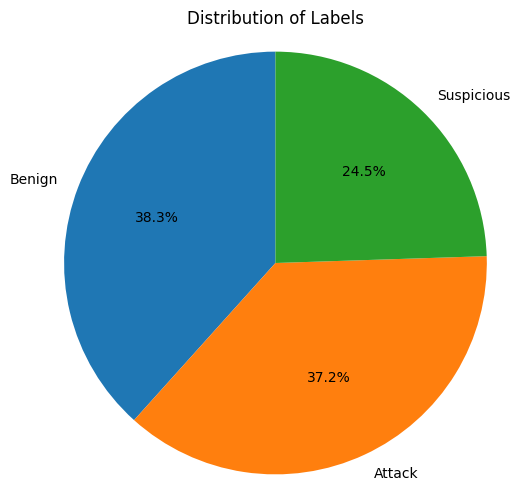

In [59]:
# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label, labels=label.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

##Saving final version of dataset pre-feature importance

In [60]:
df.to_csv('/content/drive/MyDrive/cloud-DDOS-v2.csv', index=False)

# 3. Data Analysis

In [61]:
df = pd.read_csv('/content/drive/MyDrive/cloud-DDOS-v2.csv')

In [62]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

I'm just verifying that the previously loaded CSV has the correct data types (casting).

In [63]:
df.dtypes

,0
duration,float64
packets_count,int64
fwd_packets_count,int64
bwd_packets_count,int64
total_payload_bytes,int64
fwd_total_payload_bytes,int64
bwd_total_payload_bytes,int64
payload_bytes_max,int64
payload_bytes_min,int64
payload_bytes_mean,float64


## Set Train and Test

In this section, I will manually demonstrate feature selection, the correlation matrix, and outlier detection. However, during the actual training phase, these operations will be managed automatically by the pipeline.

In [64]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split

x = df.drop(columns=['label'])
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

I check that there are no inf value which may mean that i had some errors in the previous saving of the preprocessing steps

In [65]:
mask = df.isin([np.inf, -np.inf]).any(axis=1)
rows_with_inf = df[mask]

print(f"Numero righe con val inf: {len(rows_with_inf)}")

print("\nRighe con val inf:")
rows_with_inf

Numero righe con val inf: 0

Righe con val inf:


,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,payload_bytes_median,payload_bytes_skewness,payload_bytes_cov,payload_bytes_mode,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,fwd_payload_bytes_median,fwd_payload_bytes_skewness,fwd_payload_bytes_cov,fwd_payload_bytes_mode,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,bwd_payload_bytes_median,bwd_payload_bytes_skewness,bwd_payload_bytes_cov,bwd_payload_bytes_mode,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,median_header_bytes,skewness_header_bytes,cov_header_bytes,mode_header_bytes,variance_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,fwd_median_header_bytes,fwd_skewness_header_bytes,fwd_cov_header_bytes,fwd_mode_header_bytes,fwd_variance_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,bwd_median_header_bytes,bwd_skewness_header_bytes,bwd_cov_header_bytes,bwd_mode_header_bytes,bwd_variance_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,active_median,active_skewness,active_cov,active_mode,active_variance,idle_min,idle_max,idle_mean,idle_std,idle_median,idle_skewness,idle_cov,idle_mode,idle_variance,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,fin_flag_percentage_in_total,psh_flag_percentage_in_total,urg_flag_percentage_in_total,ece_flag_percentage_in_total,syn_flag_percentage_in_total,ack_flag_percentage_in_total,cwr_flag_percentage_in_total,rst_flag_percentage_in_total,fwd_fin_flag_percentage_in_total,fwd_psh_flag_percentage_in_total,fwd_urg_flag_percentage_in_total,fwd_ece_flag_percentage_in_total,fwd_syn_flag_percentage_in_total,fwd_ack_flag_percentage_in_total,fwd_cwr_flag_percentage_in_total,fwd_rst_flag_percentage_in_total,bwd_fin_flag_percentage_in_total,bwd_psh_flag_percentage_in_total,bwd_urg_flag_percentage_in_total,bwd_ece_flag_percentage_in_total,bwd_syn_flag_percentage_in_total,bwd_ack_flag_percentage_in_total,bwd_cwr_flag_percentage_in_total,bwd_rst_flag_percentage_in_total,fwd_fin_flag_percentage_in_fwd_packets,fwd_psh_flag_percentage_in_fwd_packets,fwd_urg_flag_percentage_in_fwd_packets,fwd_ece_flag_percentage_in_fwd_packets,fwd_syn_flag_percentage_in_fwd_packets,fwd_ack_flag_percentage_in_fwd_packets,fwd_cwr_flag_percentage_in_fwd_packets,fwd_rst_flag_percentage_in_fwd_packets,bwd_fin_flag_percentage_in_bwd_packets,bwd_psh_flag_percentage_in_bwd_packets,bwd_urg_flag_percentage_in_bwd_packets,bwd_ece_flag_percentage_in_bwd_packets,bwd_syn_flag_percentage_in_bwd_packets,bwd_ack_flag_percentage_in_bwd_packets,bwd_cwr_flag_percentage_in_bwd_packets,bwd_rst_flag_percentage_in_bwd_packets,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,packets_IAT_median

## Manual Feature Selection

Since I have over 300 columns, I've decided to display the top 25 most important features to identify which ones are essential for the model.

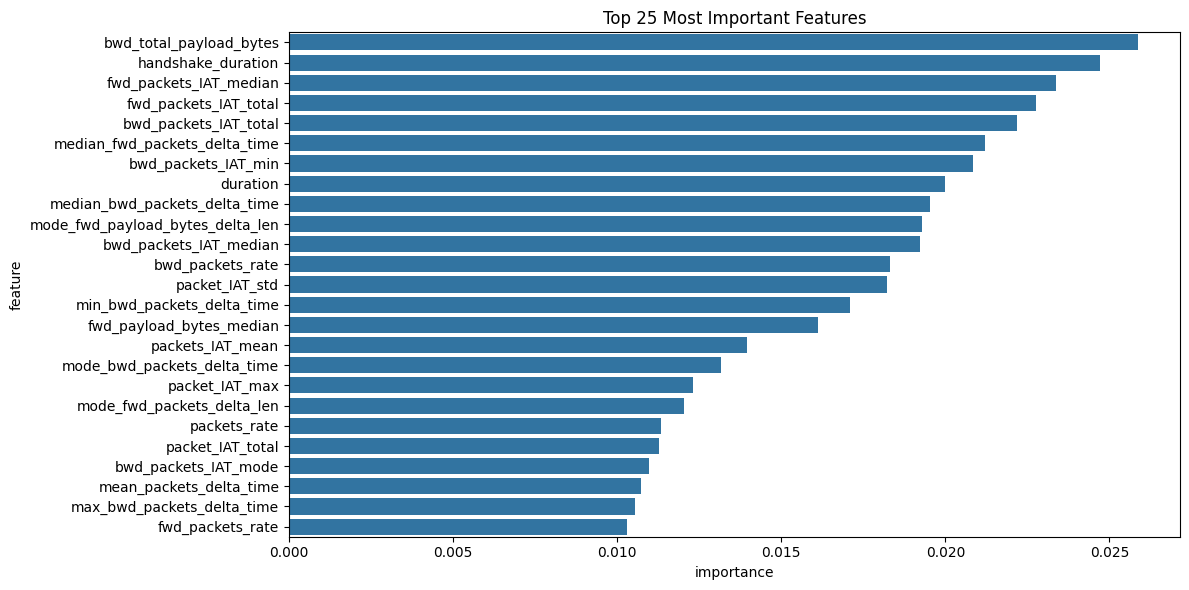

In [66]:
# 1. Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': importances
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(25), x='importance', y='feature')
plt.title('Top 25 Most Important Features')
plt.tight_layout()
plt.show()

I've set a threshold of 0.010, which allows me to retain only the most important features, resulting in 28 columns.

In [67]:
# Select features above threshold
threshold = 0.010
important_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()
X_train_important = x_train[important_features]
X_test_important = x_test[important_features]

In [68]:
print(f"Number of remaining features: {len(important_features)}")

Number of remaining features: 28


## Correlation Matrix

I'm now using a correlation matrix to check the correlation among the different features.

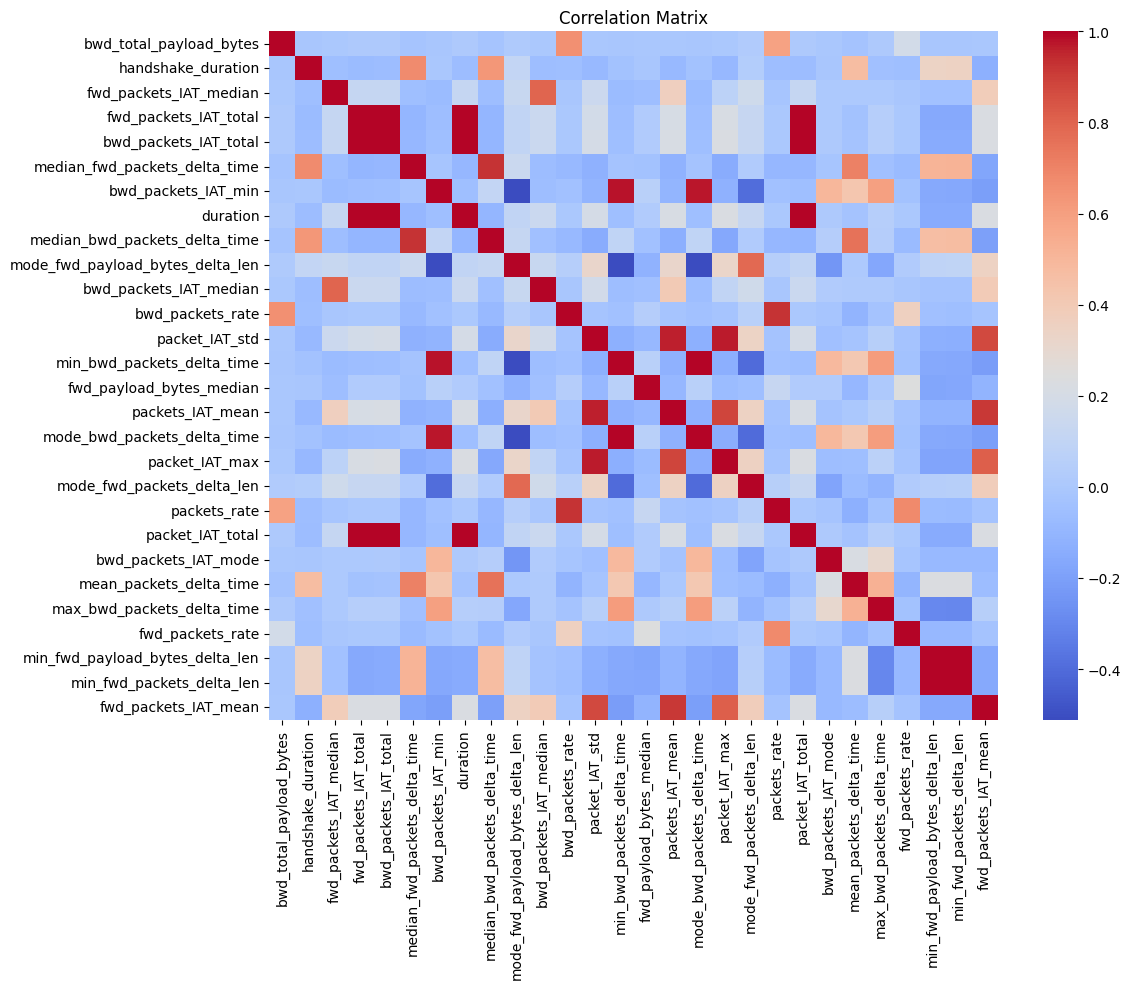

In [69]:
# 2. Correlation Analysis
correlation_matrix = X_train_important.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Remove highly correlated features
threshold_corr = 0.9
correlation_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold_corr:
            colname = correlation_matrix.columns[i]
            correlation_features.add(colname)

X_train_decorr = X_train_important.drop(columns=correlation_features)
X_test_decorr = X_test_important.drop(columns=correlation_features)

## Outlier Detection

In this section i check the presence of outlier in my dataset by checking all of them divided by class.

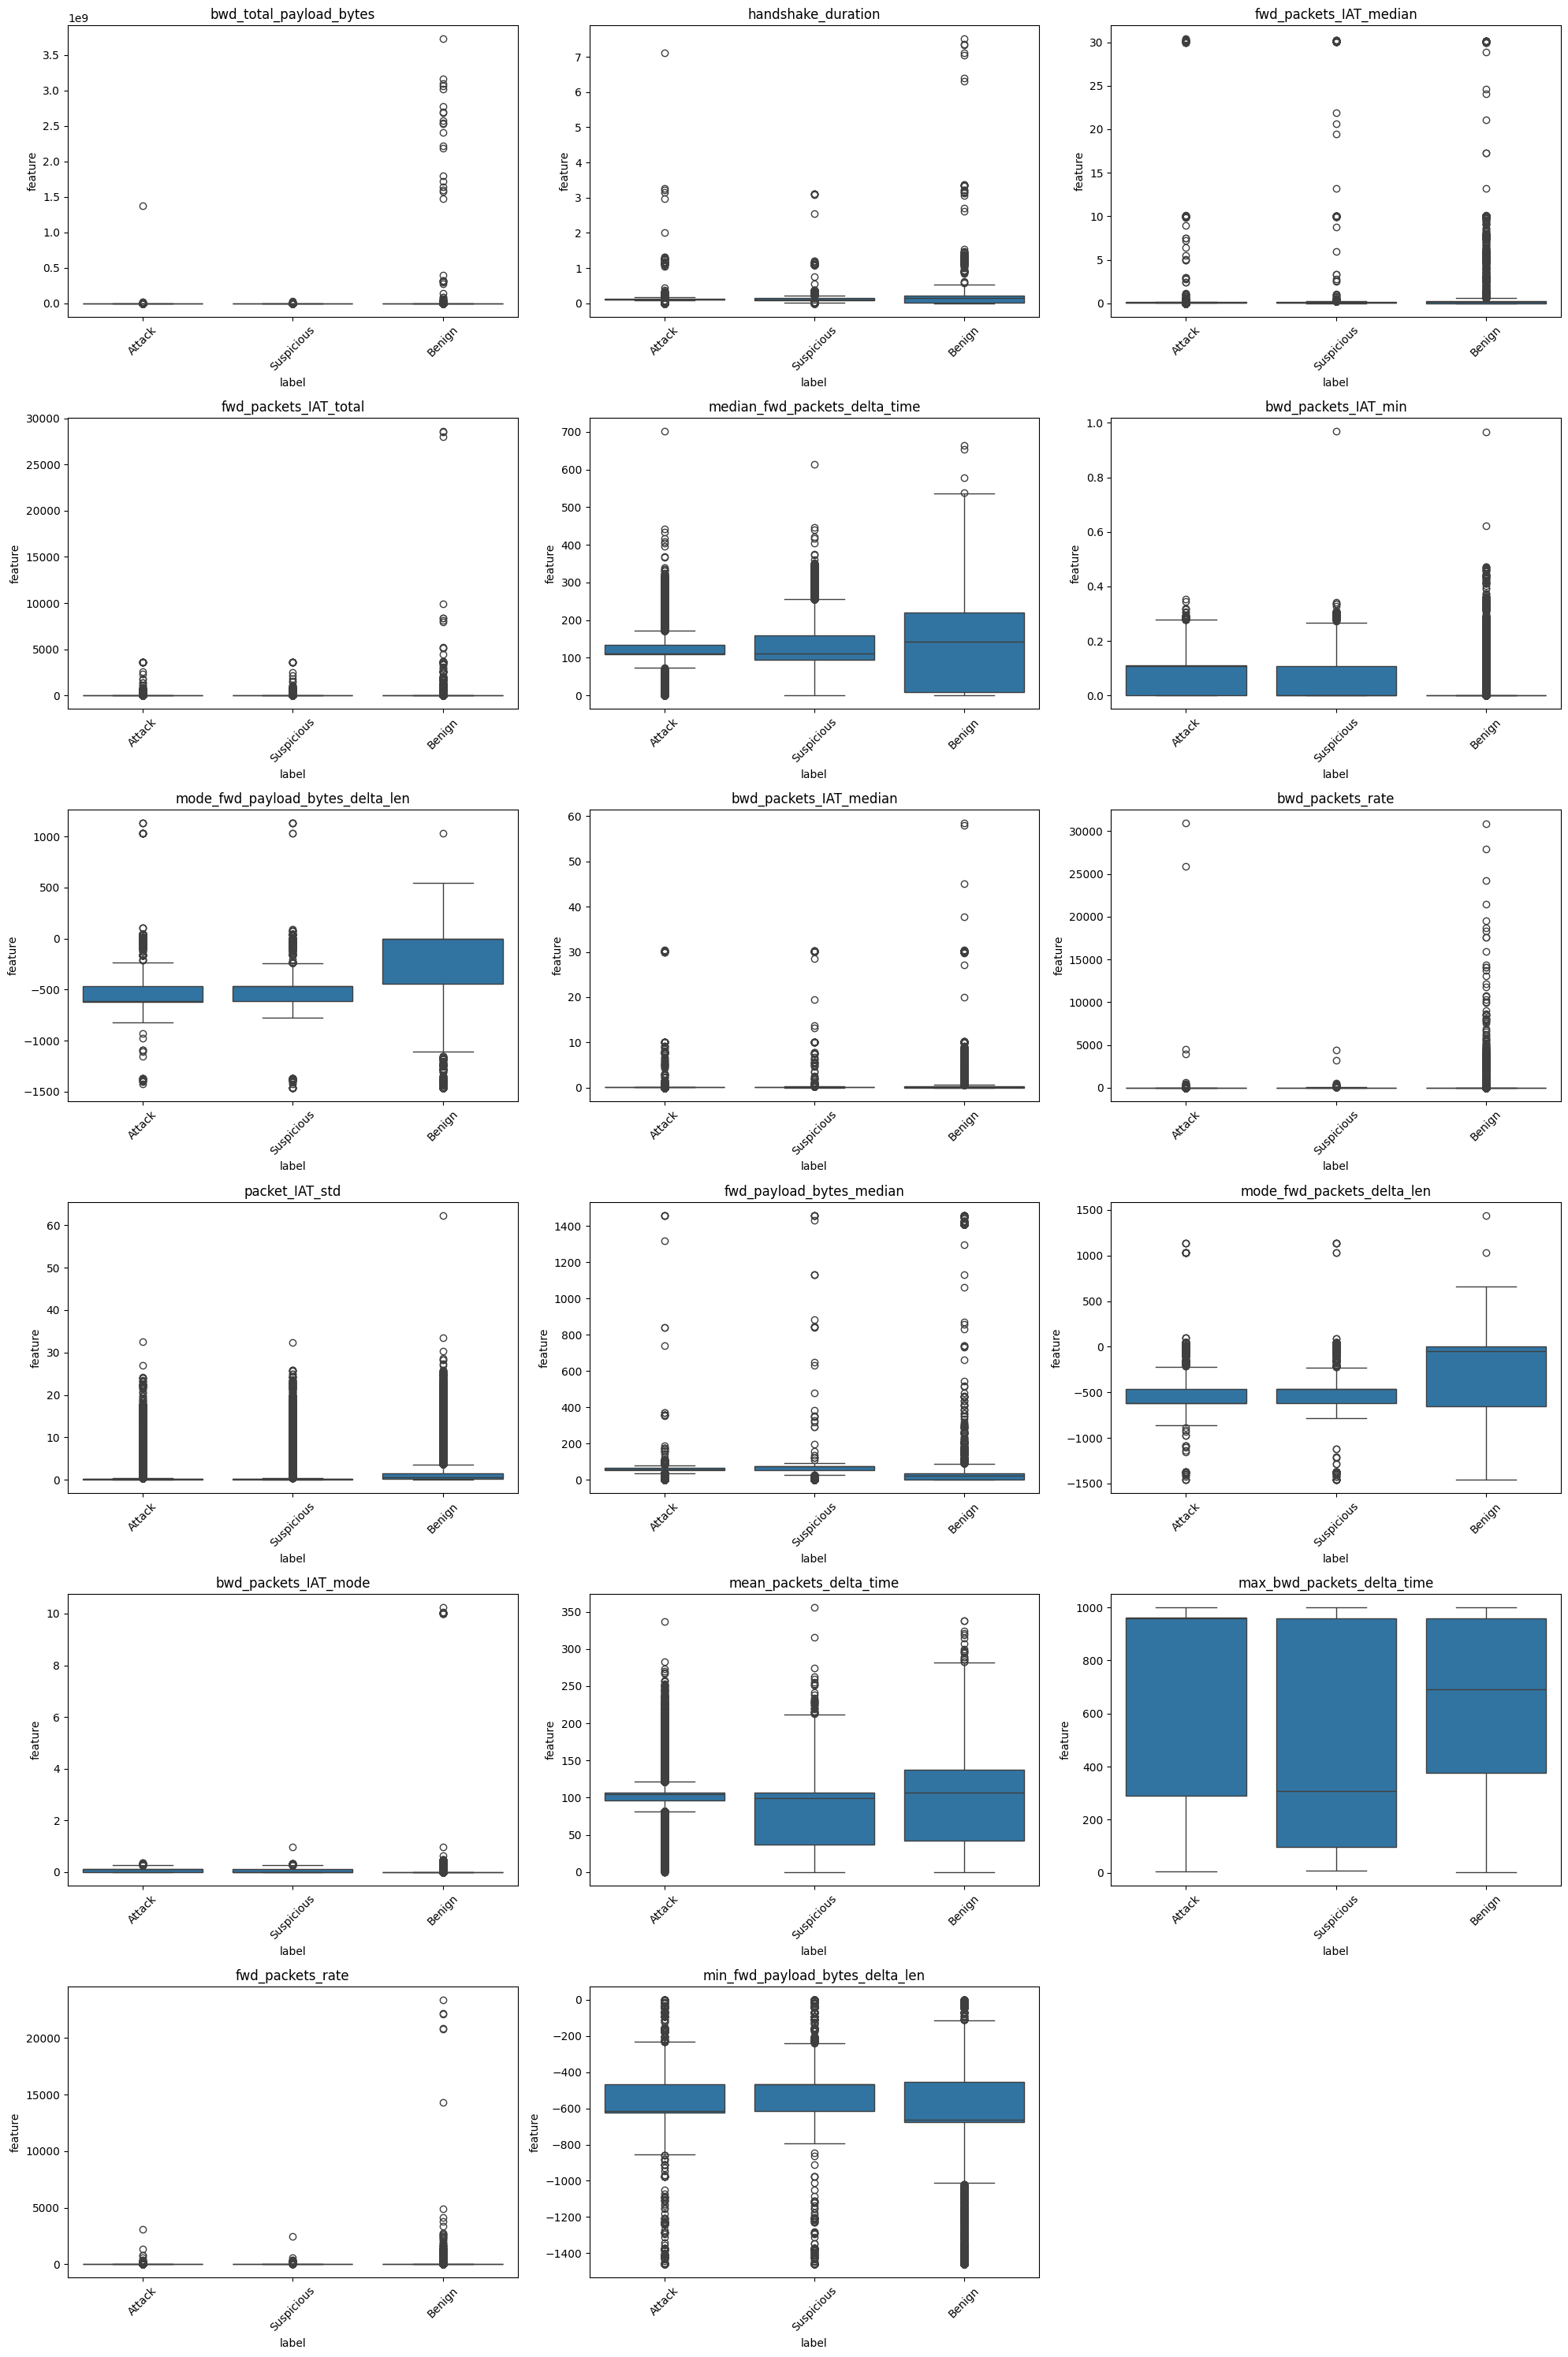

In [70]:
# Create boxplots of the features, 3 per row
num_features = len(X_train_decorr.columns)
num_rows = (num_features + 2) // 3  # Calculate the number of rows needed

plt.figure(figsize=(20, 5 * num_rows))

for i, feature in enumerate(X_train_decorr.columns):
    plt.subplot(num_rows, 3, i + 1)
    temp=pd.DataFrame({
        'feature': X_train_decorr[feature],
        'label': y_train
    })
    sns.boxplot(data=temp,x='label',y='feature')
    plt.title(f'{feature}')
    plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

I've observed numerous outliers in several columns, predominantly associated with a single class. If I were to remove them, I'd risk significantly hindering the classification of that specific class by eliminating potentially valuable information. For this reason, I've decided **not to drop** the outliers and will keep them in the dataset.

In [71]:
print(f"Number of remaining features after feature importance and correlation analysis: {len(X_train_decorr.columns)}")
print("\nRemaining features:")
print(*X_train_decorr.columns.tolist(), sep='\n')

Number of remaining features after feature importance and correlation analysis: 17

Remaining features:
bwd_total_payload_bytes
handshake_duration
fwd_packets_IAT_median
fwd_packets_IAT_total
median_fwd_packets_delta_time
bwd_packets_IAT_min
mode_fwd_payload_bytes_delta_len
bwd_packets_IAT_median
bwd_packets_rate
packet_IAT_std
fwd_payload_bytes_median
mode_fwd_packets_delta_len
bwd_packets_IAT_mode
mean_packets_delta_time
max_bwd_packets_delta_time
fwd_packets_rate
min_fwd_payload_bytes_delta_len


After all these operations, I'll have only 17 columns remaining, a significant reduction from the over 300 we started with.

#4. Training the model

In this cell i at first did the hyper parameterization, now it is only shown the best parameters, just for simplicity of execution.
The values that i tried were the following:

1.   n_estimators: [50, 100, 200]
2.   max_depth: [10,20]
3.   min_samples_split: [2,5]
4.   min_samples_leaf: [1, 2, 4]
5.   feature_selection_k: 25

The last parameter were used only because of SelectKBest of the Pipeline.


In [72]:
# Train final model for manual path using cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif,k=20)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'feature_selection__k': [25]
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=
    {
        'accuracy':'accuracy',
        'f1':'f1_weighted'
    },
    refit='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit the model using cross-validation
grid_search.fit(x_train, y_train)

# Get best model and make predictions
best_model = grid_search.best_estimator_
y_pred_manual = best_model.predict(x_test)

print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nResults:")
print(classification_report(y_test, y_pred_manual))

print("Accuracy Score:", grid_search.cv_results_['mean_test_accuracy'])
print("F1 score", grid_search.cv_results_['mean_test_f1'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  8  17  26 118 142 158 208 267] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Best parameters found:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'feature_selection__k': 25}

Results:
              precision    recall  f1-score   support

      Attack       0.78      0.91      0.84     11642
      Benign       0.92      0.99      0.95     11658
  Suspicious       0.92      0.56      0.70      7637

    accuracy                           0.86     30937
   macro avg       0.87      0.82      0.83     30937
weighted avg       0.87      0.86      0.85     30937

Accuracy Score: [0.85785284]
F1 score [0.84901499]


The confusion matrix confirms the previous findings: the attack predictions are slightly worse than the other two categories. This is because the model misclassifies some suspicious instances as attacks due to their similarity.

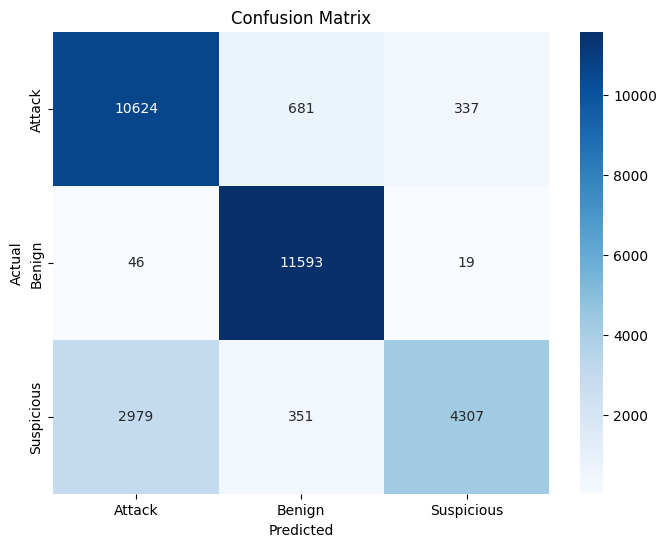

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_manual)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

I can see that the comparison between the train accuracy and test accuracy shows a difference of 0.0058 and for the f1 score a difference of 0.0061.

This shows that our model has good performances.

In [74]:
from sklearn.metrics import accuracy_score, f1_score

# Performance sul training set
y_pred_train = best_model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Performance sul test set
y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1-score: {train_f1:.4f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Calcola la differenza tra training e test
print("\nDifferenza tra Training e Test:")
print(f"Accuracy difference: {train_accuracy - test_accuracy:.4f}")
print(f"F1-score difference: {train_f1 - test_f1:.4f}")

Training Metrics:
Accuracy: 0.8632
F1-score: 0.8550

Test Metrics:
Accuracy: 0.8574
F1-score: 0.8488

Differenza tra Training e Test:
Accuracy difference: 0.0058
F1-score difference: 0.0061


The learning curve indicates that the training accuracy (blue) is initially higher but shows a slight decrease as more data is utilized. Conversely, the validation accuracy (red) starts lower but gradually increases, suggesting that the model generalizes better with more data. The observed gap between the two curves points to some bias, yet low variance

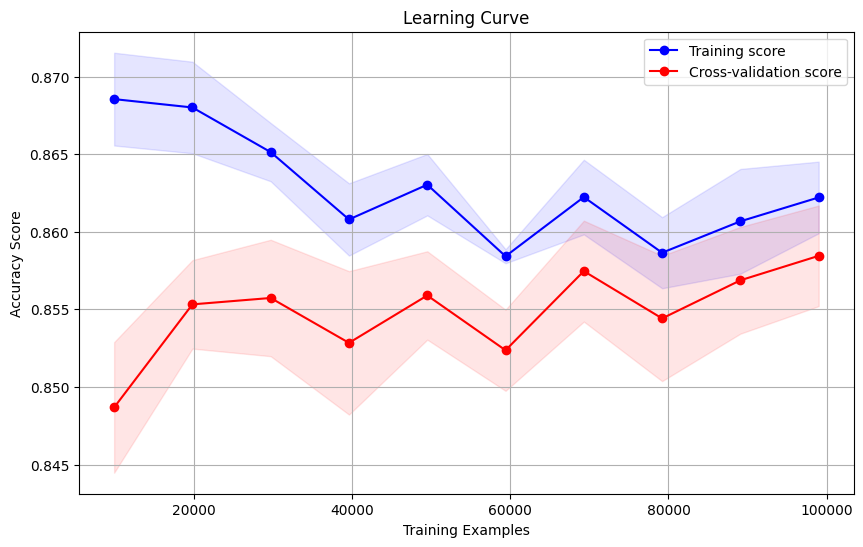

In [75]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Calcola la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, x_train, y_train,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calcola media e deviazione standard
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red', marker='o')

# Aggiungi le aree di deviazione standard
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)

plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 5. Comparison between models

## Evaluation and training

In this section i compare the Random Forest, Decision forest, Gaussian Naive Bayes and Logistic Regression to check which model behave better.

The following code setup the function which will do the training and evaluation of the model. It setup the pipeline, the list of models to try and the score metrics that will be used.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. Valutation and training of all models
# =============================================================================

def train_and_evaluate_models(x_train, x_test, y_train, y_test):
    models = {}
    results = {}

    model_configs = [
        {
            'name': 'Random Forest',
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=25)),
                ('classifier', RandomForestClassifier(
                    n_estimators=100, max_depth=10,
                    min_samples_split=2, min_samples_leaf=1,
                    random_state=42
                ))
            ])
        },
        {
            'name': 'Logistic Regression',
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=20)),
                ('classifier', LogisticRegression(
                    C=0.1, max_iter=1000, random_state=42
                ))
            ])
        },
        {
            'name': 'Gaussian Naive Bayes',
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=20)),
                ('classifier', GaussianNB())
            ])
        },
        {
            'name': 'Decision Tree',
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif, k=20)),
                ('classifier', DecisionTreeClassifier(
                    max_depth=10, random_state=42
                ))
            ])
        }
    ]

    # Training e valutazione di ogni modello
    for config in model_configs:
        print(f"Training {config['name']}...")

        # Addestramento
        model = config['pipeline']
        model.fit(x_train, y_train)

        # Predizioni
        y_pred = model.predict(x_test)
        y_pred_proba = model.predict_proba(x_test) if hasattr(model, 'predict_proba') else None

        # Calcolo metriche
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        precision_macro = precision_score(y_test, y_pred, average='macro')
        recall_macro = recall_score(y_test, y_pred, average='macro')

        # ROC AUC per multiclasse (One-vs-Rest)
        try:
            roc_auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
        except:
            roc_auc_ovr = np.nan

        # Salvataggio risultati
        models[config['name']] = model
        results[config['name']] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'roc_auc_ovr': roc_auc_ovr,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

    return models, results

### Compare models evaluations

This cell setup the function which will show the different graphs for the different metrics that i used.

In [77]:
# =============================================================================
# 2. Comparison visualization
# =============================================================================

def plot_metrics_comparison(results):
    """
    Create a bar graph
    """
    metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro', 'roc_auc_ovr']
    model_names = list(results.keys())

    data = []
    for model in model_names:
        row = [results[model][metric] for metric in metrics]
        data.append(row)

    df_metrics = pd.DataFrame(data, columns=metrics, index=model_names)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, metric in enumerate(metrics):
        df_metrics[metric].plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Score')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

        for j, v in enumerate(df_metrics[metric]):
            if not np.isnan(v):
                axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return df_metrics

def plot_confusion_matrices(results, y_test):
    """
    Create confusion matrix for all models
    """
    n_models = len(results)
    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*5))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()

    class_names = np.unique(y_test)

    for i, (model_name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[i])
        axes[i].set_title(f'{model_name}', fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    for i in range(len(results), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_roc_curves_multiclass(results, y_test):
    """
    Plot ROC curves multiclass classification (One-vs-Rest)
    """
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, (model_name, result) in enumerate(results.items()):
        if result['y_pred_proba'] is None:
            axes[idx].text(0.5, 0.5, 'ROC not available\nfor this model',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(f'{model_name}')
            continue

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i, color in zip(range(n_classes), colors):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], result['y_pred_proba'][:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            axes[idx].plot(fpr[i], tpr[i], color=color, lw=2,
                          label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

        axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{model_name}')
        axes[idx].legend(loc="lower right", fontsize=8)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_performance_summary(results):

    summary_data = []

    for model_name, result in results.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{result['accuracy']:.4f}",
            'F1-Score (Macro)': f"{result['f1_macro']:.4f}",
            'F1-Score (Weighted)': f"{result['f1_weighted']:.4f}",
            'Precision (Macro)': f"{result['precision_macro']:.4f}",
            'Recall (Macro)': f"{result['recall_macro']:.4f}",
            'ROC-AUC (OvR)': f"{result['roc_auc_ovr']:.4f}" if not np.isnan(result['roc_auc_ovr']) else 'N/A'
        })

    df_summary = pd.DataFrame(summary_data)

    print("="*80)
    print("SUMMARY OF MODEL PERFORMANCE")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("\n" + "="*80)

    numeric_cols = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']
    ranking_data = []

    for model_name, result in results.items():
        avg_score = np.mean([result[col] for col in numeric_cols])
        ranking_data.append({
            'Model': model_name,
            'Average Score': avg_score
        })

    df_ranking = pd.DataFrame(ranking_data).sort_values('Average Score', ascending=False)

    print("MODEL RANKING (by average score):")
    print("-" * 40)
    for i, row in df_ranking.iterrows():
        print(f"{row.name + 1}. {row['Model']}: {row['Average Score']:.4f}")

    return df_summary, df_ranking



This cell setup the function which will be start the training, the plotting of all the different graphs and will also give the summary.

In [78]:
# =============================================================================
# 3. Complete execution
# =============================================================================

def run_complete_comparison(x_train, x_test, y_train, y_test):
    print("Starting comprehensive model comparison...")
    print("="*60)

    # 1. Training and evaluation
    models, results = train_and_evaluate_models(x_train, x_test, y_train, y_test)

    # 2. Visualization
    print("\n1. Metrics Comparison:")
    df_metrics = plot_metrics_comparison(results)

    print("\n2. Confusion Matrices:")
    plot_confusion_matrices(results, y_test)

    print("\n3. ROC Curves (One-vs-Rest):")
    plot_roc_curves_multiclass(results, y_test)

    # 3. Summary
    print("\n4. Performance Summary:")
    df_summary, df_ranking = create_performance_summary(results)

    return models, results, df_metrics, df_summary, df_ranking

I can see all the AUC curves for the models. The Decision Tree and Random Forest models show the best performance. Given my objective of achieving higher precision and higher recall, the Random Forest model is the most suitable.

My preference for high precision and high recall stems from the nature of the problem: misclassifying a benign instance as malignant is less severe than the reverse. Specifically, for malignant instances, it's crucial to have both high precision and high recall. This ensures that genuine attacks are not missed by the model, while also minimizing false negatives. For benign instances, misclassifications are less critical; if a benign instance is labeled as malignant, it doesn't pose significant issues.

Starting comprehensive model comparison...
Training Random Forest...
Training Logistic Regression...
Training Gaussian Naive Bayes...
Training Decision Tree...

1. Metrics Comparison:


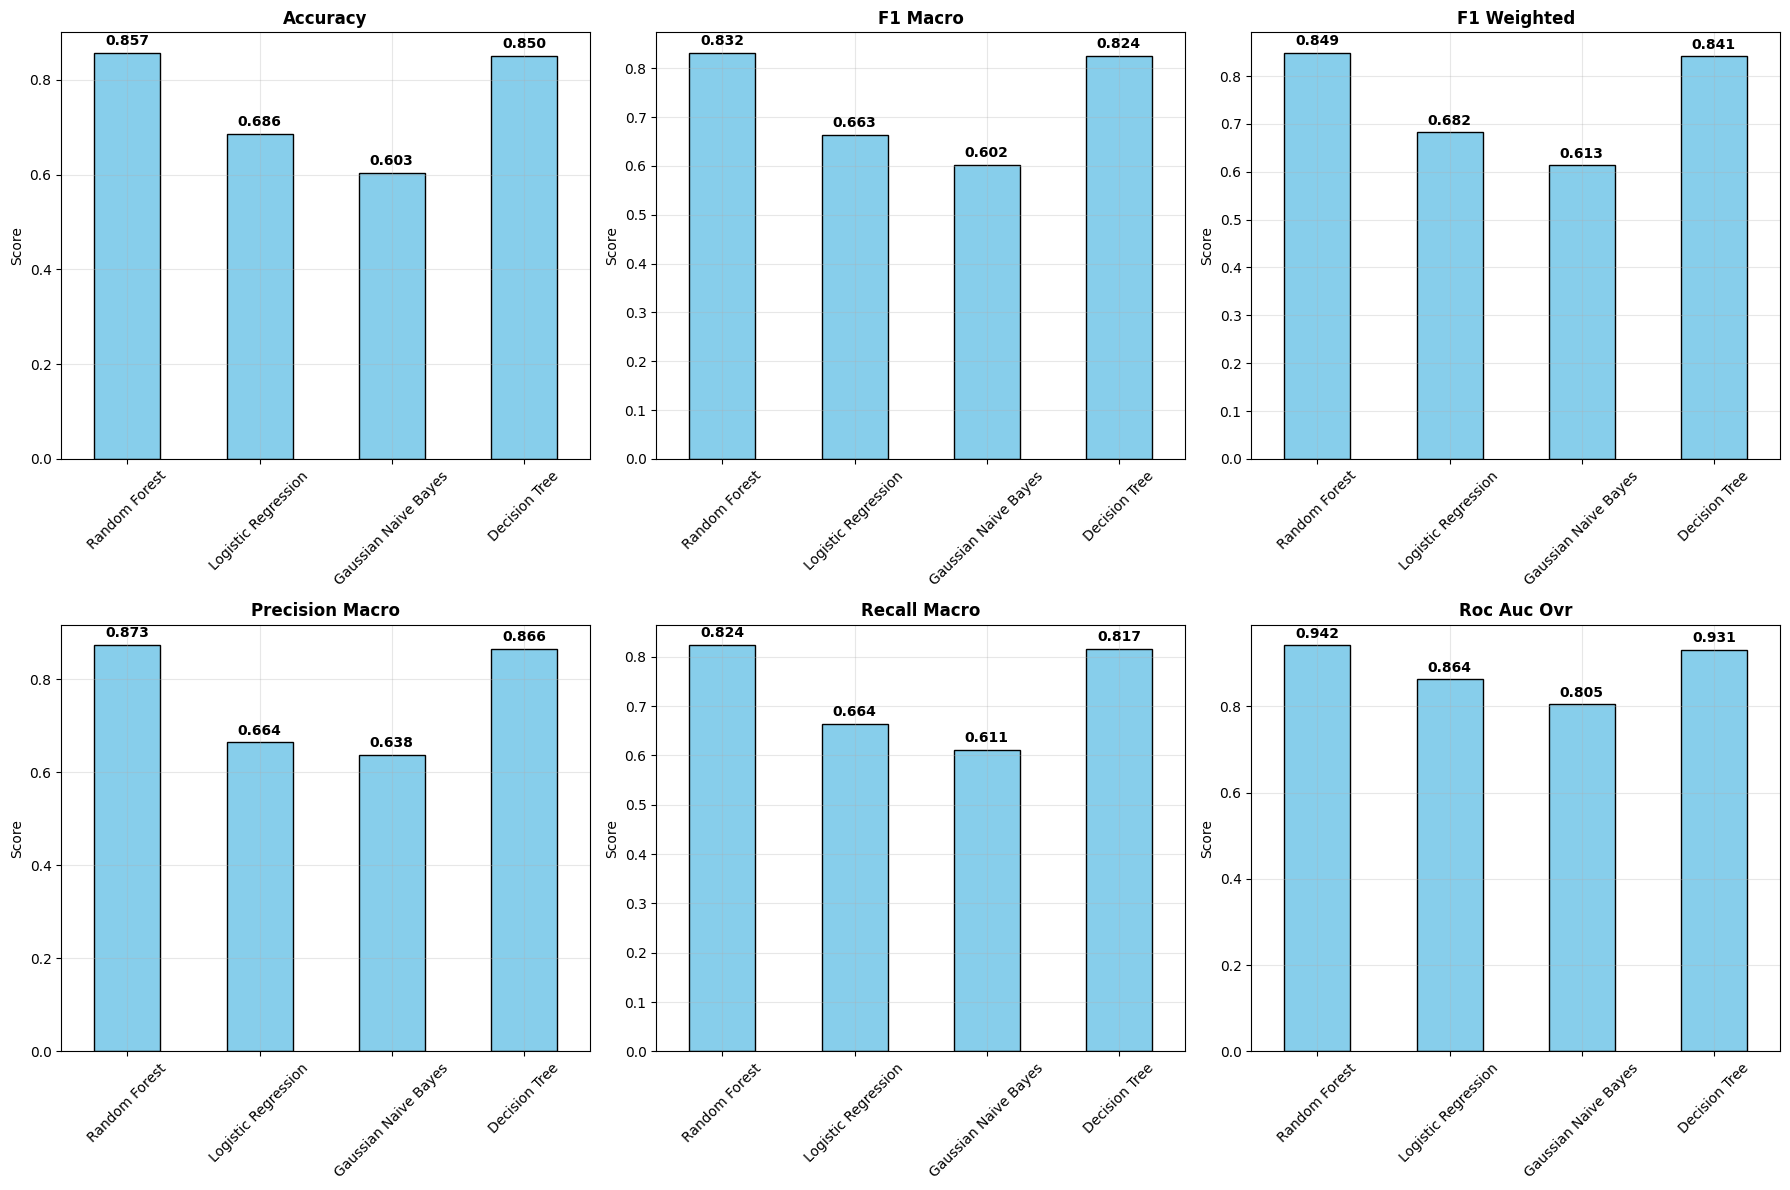


2. Confusion Matrices:


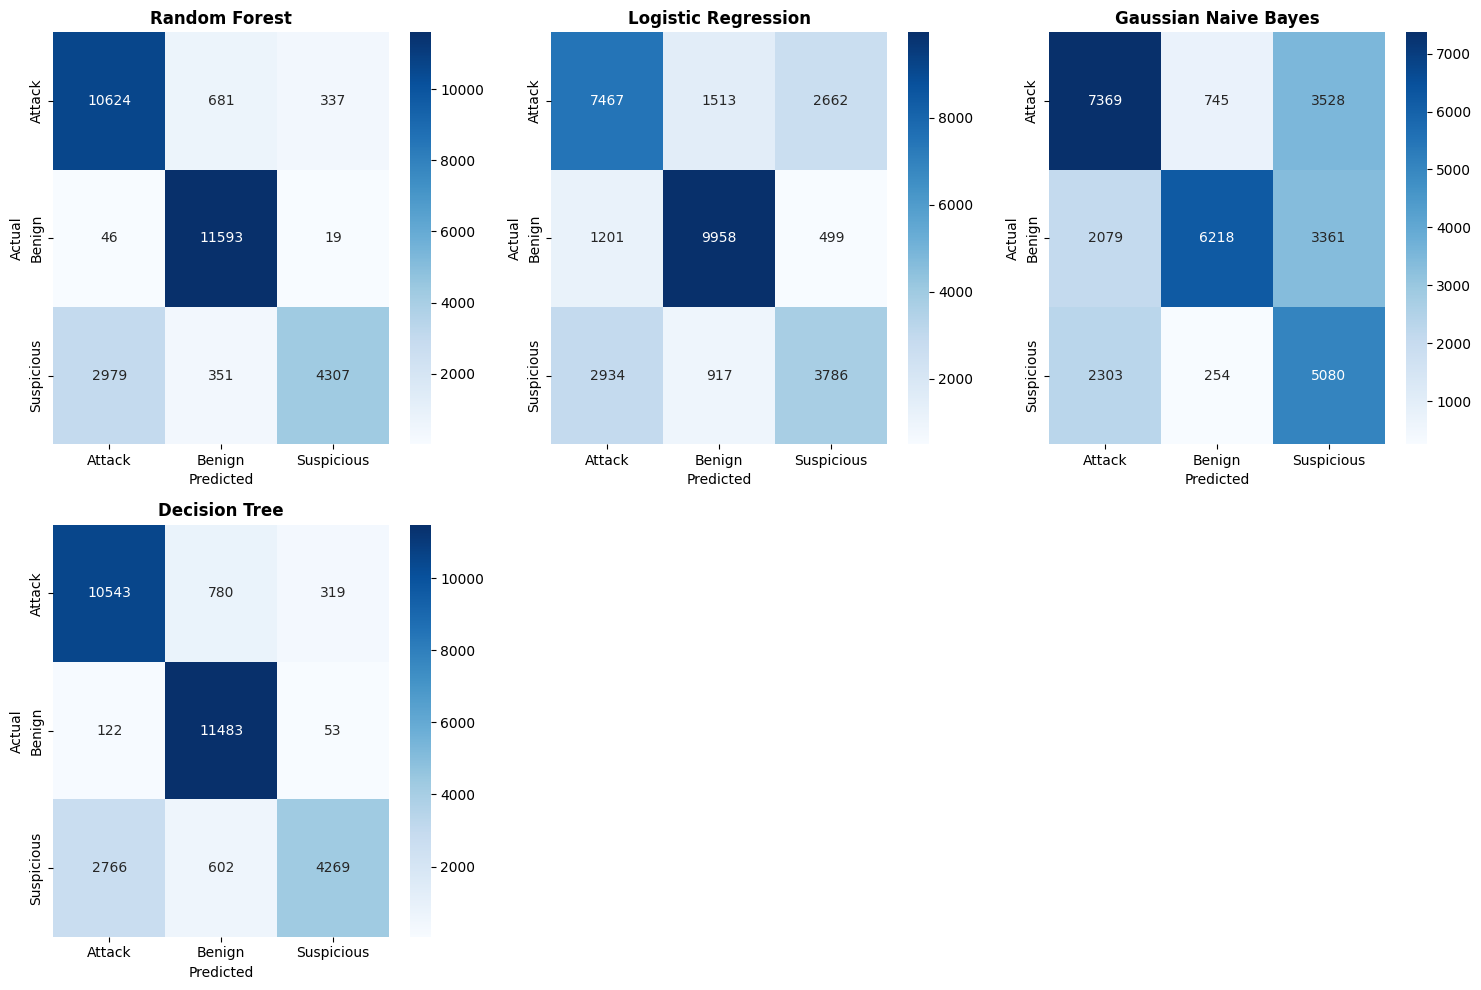


3. ROC Curves (One-vs-Rest):


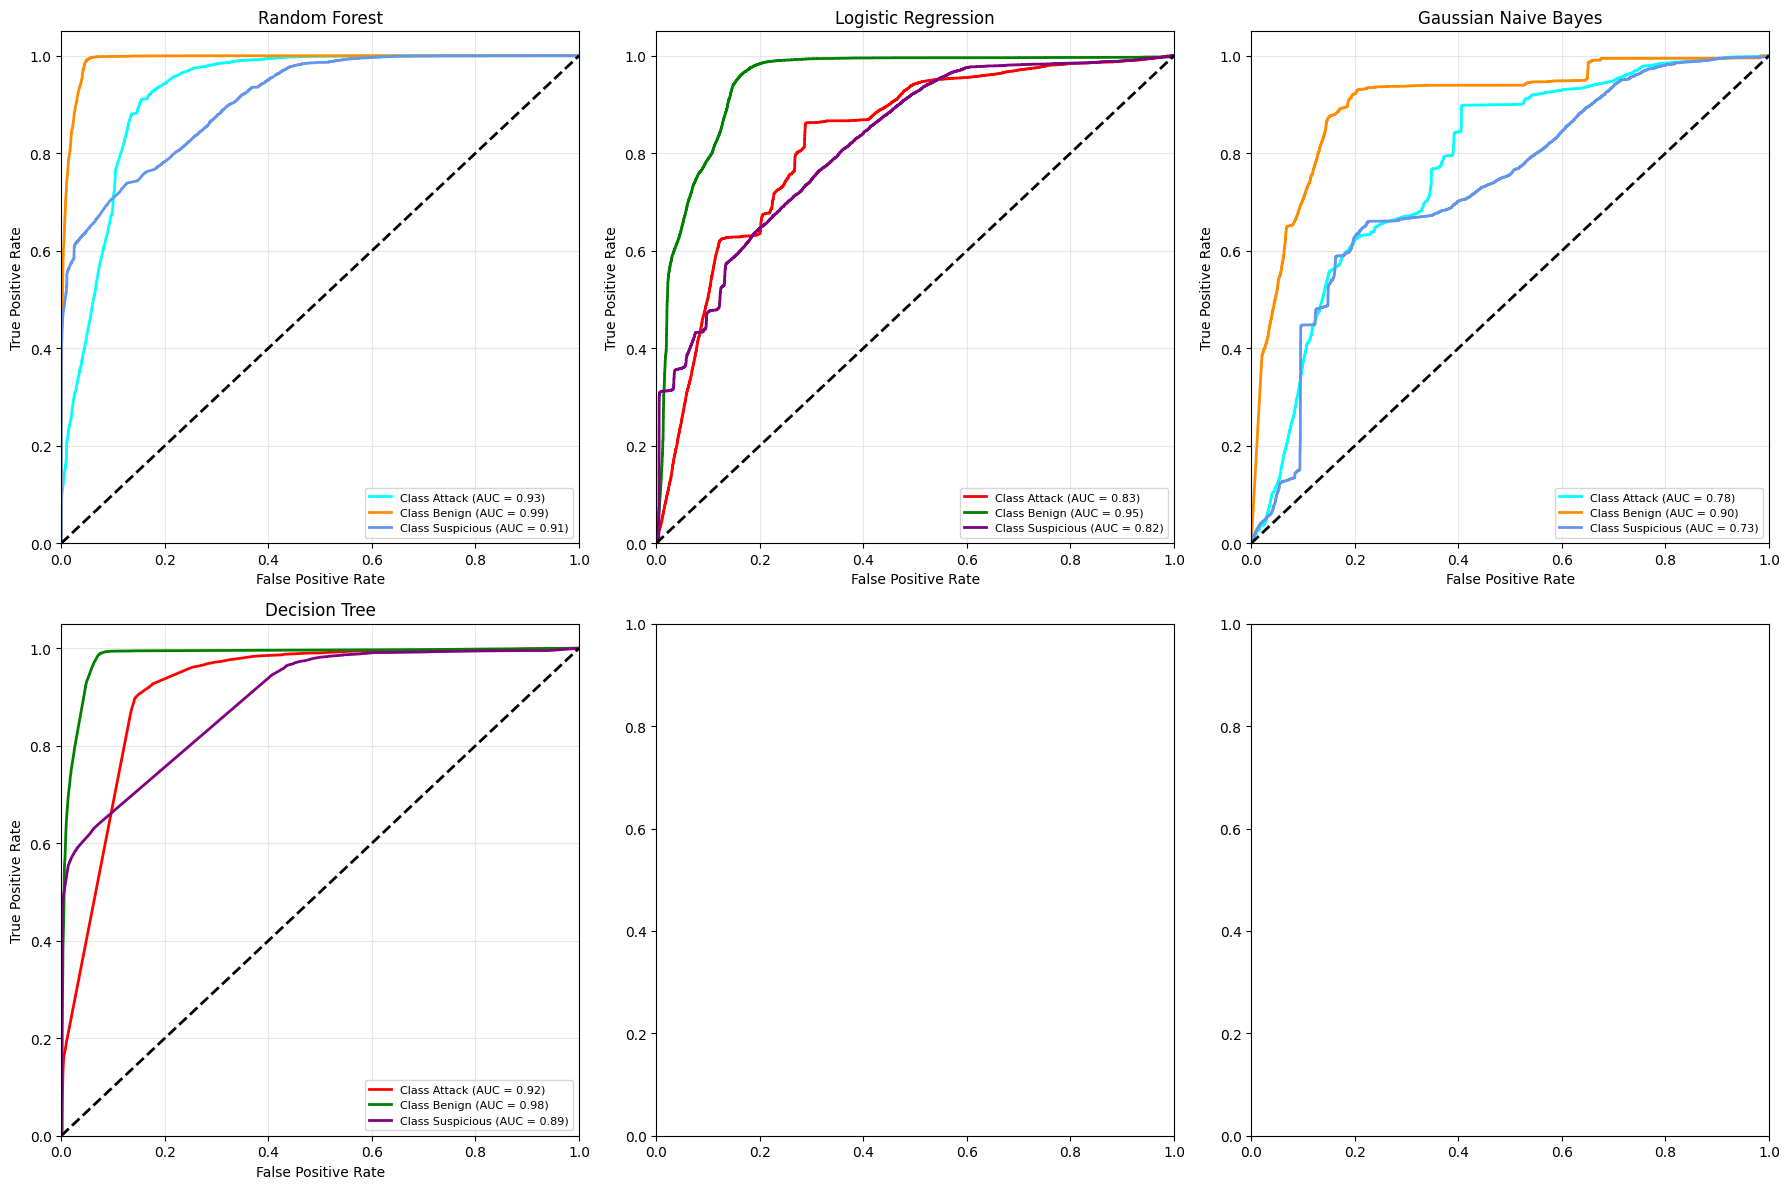


4. Performance Summary:
SUMMARY OF MODEL PERFORMANCE
               Model Accuracy F1-Score (Macro) F1-Score (Weighted) Precision (Macro) Recall (Macro) ROC-AUC (OvR)
       Random Forest   0.8574           0.8318              0.8488            0.8734         0.8236        0.9418
 Logistic Regression   0.6856           0.6633              0.6821            0.6641         0.6638        0.8637
Gaussian Naive Bayes   0.6034           0.6024              0.6133            0.6377         0.6105        0.8048
       Decision Tree   0.8500           0.8243              0.8410            0.8658         0.8165        0.9314

MODEL RANKING (by average score):
----------------------------------------
1. Random Forest: 0.8470
4. Decision Tree: 0.8395
2. Logistic Regression: 0.6718
3. Gaussian Naive Bayes: 0.6134

5. Final Results:
                  Model Accuracy F1-Score (Macro) F1-Score (Weighted)  \
0         Random Forest   0.8574           0.8318              0.8488   
1   Logistic Regressio

In [79]:
# Esegui il confronto completo
models, results, df_metrics, df_summary, df_ranking = run_complete_comparison(
    x_train, x_test, y_train, y_test
)

print("\n5. Final Results:")
print(df_summary)
print(df_ranking)

# Conclusion

After training and evaluating multiple classification models on our cleaned dataset, we compared their performance across several metrics, including accuracy, F1-score, precision, and recall.

The Random Forest model consistently delivered the best results. It particularly excelled in macro and weighted F1-score, and notably, in recall for the 'attack' class.

Given the critical nature of real-time DDoS attack detection, minimizing false negatives is our top priority. A false negative in this scenario means a malicious attack is incorrectly classified as normal traffic, which could lead to severe security breaches.

Therefore, we prefer the Random Forest model because:

- It maintains high recall on the 'attack' class, significantly reducing the risk of missing actual threats.
- It also provides balanced performance across all classes, which ensures that normal traffic isn't over-penalized by unnecessary false positives.